# Hello World, 🏁 TurboZero!

In this notebook we'll walk through how to use each of the core features of TurboZero. We will walk through the following features:
1. Training a model from scratch
2. Loading a checkpoint + continuing training
3. Evaluating our trained model against different baselines
4. Running a tournament with baseline algorithms pitted against a few different configurations of our trained model
5. Playing against our trained model

## Setup

First, you'll want to clone the turbozero repo, if you haven't already.




In [ ]:
! git clone https://github.com/lowrollr/turbozero.git && cd turbozero
%cd turbozero


TurboZero uses [poetry](https://python-poetry.org) as its package/dependency managements system. 

The following command will install poetry, install the necessary dependencies, and create a kernel `turbozero` to connect to.

In [ ]:
! curl -sSL https://install.python-poetry.org | python3 - && export PATH="/root/.local/bin:$PATH" && poetry install && poetry run python -m ipykernel install --user --name turbozero

After running this command, restart the notebook and connect to the `turbozero` kernel.

## Training AlphaZero for *Othello* from Scratch

In this notebook we'll train a tiny *AlphaZero* model to play Othello. You should be able to run this on one of the free Colab GPUs in a reasonable amount of time. I was able to complete training with a T4 in ~3 hours. 

First, we'll need to write a training config file. There are a few example config files provided [here](https://github.com/lowrollr/turbozero/tree/main/example_configs), but we'll write a new one in this notebook.

Running the cell below will create a new config file `train_config.yaml`, you can edit it to overwrite the config file if you'd like to try different hyperparameters.

In [5]:
%%writefile train_config.yaml
run_tag: "othello_hello_world" # for saving and identifying checkpoints
env_config: { # configures the environment
  env_type: "othello", # type of environment
  board_size: 8 # size of Othello board (8x8)
}
model_config: { # configures ResNet architecture, see https://medium.com/applied-data-science/alphago-zero-explained-in-one-diagram-365f5abf67e0,
  res_channels: 12, # number of residual channels (or kernels in each convolutional block)
  res_blocks: 4, # number of residual blocks (containing 2x convolutions + a residual connection + batchnorm)
  kernel_size: 3, # size of convolutional kernels
  value_fc_size: 48, # size of value head's fully connected layer
  value_output_activation: "tanh0to1" # value output activation. We use a custom tanh activation that constrains output from 0 to 1
}
train_mode_config: {
  algo_config: {
    name: "alphazero", # name of algorithm used to evaluate MDP states, we're using AlphaZero, which is MCTS using a neural network to evaluate leaf nodes. Also see https://github.com/lowrollr/turbozero/wiki/Vectorized-AlphaZero#parameters
    temperature: 1.0,  # adjusts policy distribution prior to sampling an action (0.0 == argmax). we use a value higher than 0.0 to encourage exploration during training
    num_iters: 400, # 'budget' of edge traversals during MCTS (more iters -> higher quality policy, but longer runtime)
    max_nodes: 400, # maximum node capacity of MCTS data structures, any additional nodes will be treated as leafs and discarded
    puct_coeff: 1.0, # PUCT coefficient, see https://www.chessprogramming.org/UCT
    dirichlet_alpha: 0.85, # magnitude of dirichlet noise
    dirichlet_epsilon: 0.25 # fraction of dirichlet noise composing root node policy
  },
  learning_rate: 0.1, # SGD learning rate
  lr_decay_gamma: 0.95, # exponential learning rate decay factor, applied once per epoch
  momentum: 0.9, # SGD momentum
  c_reg: 0.001, # L2-regularization coefficient
  replay_memory_max_size: 5120, # maximum number of self-play episodes to store in replay memory
  replay_memory_min_size: 1024, # minimum number of self-play episodes required before allowing NN training
  parallel_envs: 1024, # number of environments to collect self-play episodes from in parallel (this can be much higher on a GPU!, reccommend 4096+)
  policy_factor: 1.0, # controls bias of overall loss towards policy loss or value loss
  minibatch_size: 1024, # size of minibatch sampled from replay memory during a training step
  episodes_per_epoch: 1024, # number of episodes to collect from self-play in an epoch
  episodes_per_minibatch: 20, # this many episodes must be collected per single training step
  test_config: { # optional evaluation step, once per epoch
    algo_config: { # this defines the algorithm's parameters during evaluation
      name: "alphazero",
      temperature: 0.0, # we set temperature to 0.0 during evaluation
      num_iters: 400,
      max_nodes: 400,
      puct_coeff: 1.0,
      dirichlet_alpha: 0.1,
      dirichlet_epsilon: 0.0 # we eliminate dirichlet noise during evaluation
    },
    episodes_per_epoch: 128,
    baselines: [ # we can define any number of additional evaluators to collect validation games against here, see https://github.com/lowrollr/turbozero/wiki/Evaluation-&-Testing#baselines
      { # we will collect 16 games against an evaluator that selects the action giving it the greatest number of tiles
        name: "greedy",
        heuristic: "num_tiles"
      },
    ]
  }
}

Overwriting train_config.yaml


We've defined parameters that configure the environment, the model we'll be training, as well as hyperparemeters for the training and evaluation steps. It's worth noting that one should scale these up considerably to acheive more desirable performance. You might be suprised at what we can acheive though!

Using this config file, we can load a `Trainer`, the module handling all things training. For a more full explanation of the `Trainer`, see its [wiki page](https://github.com/lowrollr/turbozero/wiki/Training).

In [6]:
import torch
from turbozero import load_trainer_nb

trainer = load_trainer_nb(
    config_file = 'train_config.yaml',
    gpu = torch.cuda.is_available(),
    debug = False,
    logfile = 'turbozero.log',
    verbose_logging=True
)

/content/turbozero/envs/othello/torchscripts.py:108: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  board_size = int(states.shape[-1]) # need to wrap in int() for tracing


Then, it's as simple as calling `trainer.training_loop()` to kick off the training process. Most of the output will be redirected to the logfile, but you'll see a few plots of loss/accuracy be updated along the way 😀.

A few things will happen:
* A replay memory buffer will be filled with self-play episodes, up to its minimum required amount
* 5 epoch will be collected, each with:
 * 2048 self-play episodes
 * 128 evaluation episodes against a greedy baseline
 * A training step performed once for every 15 self-play episodes collected

As game colleciton is heavily parallelized, expect the loading bar to move erratically, as batches of games will tend to finish nearly all at the same time.

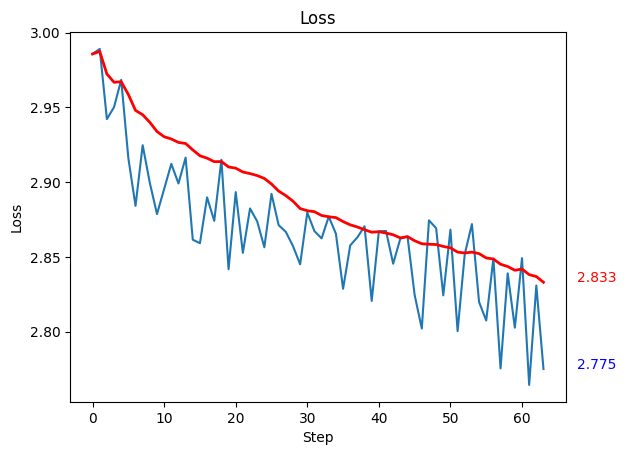

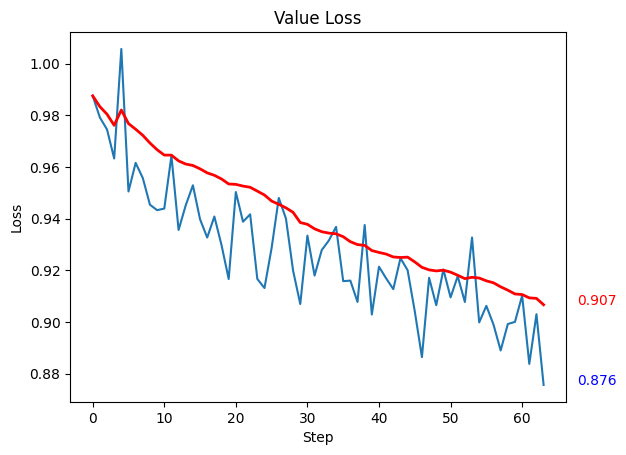

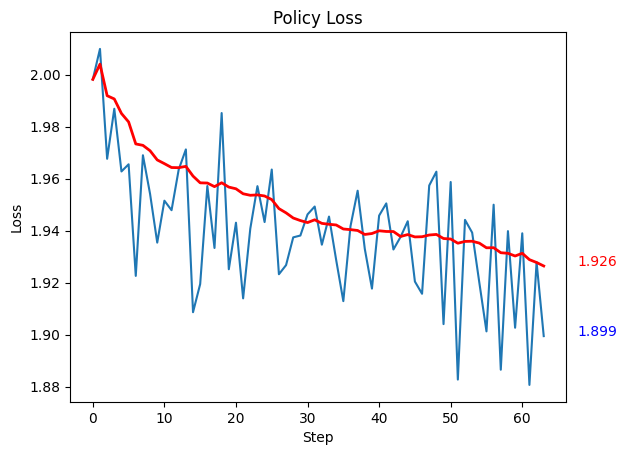

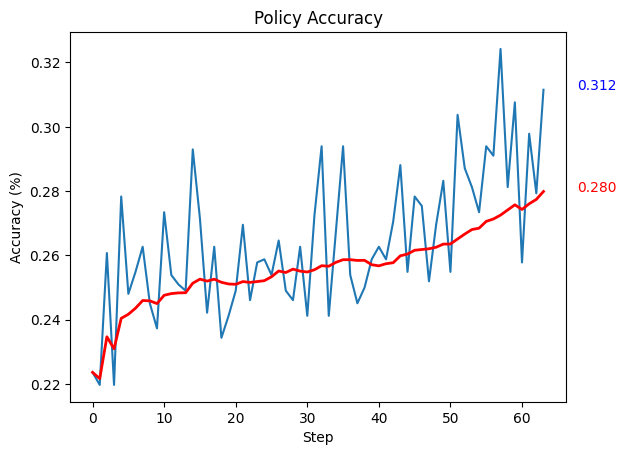

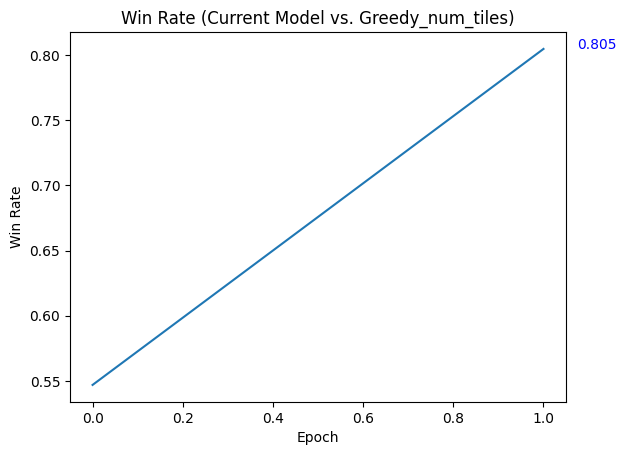

In [ ]:
trainer.training_loop(epochs=5)

Hopefully you see that loss metrics are improving, and that performance against the greedy baseline is improving as well!

After every epoch, a training checkpoint will be saved. You'll be able to find the saved checkpoints in `./checkpoints/{run_tag}/{chuckpoint_num}.pt`.

So our most recent checkpoint can be found in `./checkpoints/othello_hello_world/5.pt`

We could load the checkpoint and continue training like this:

In [6]:
# trainer = load_trainer_nb(
#     config_file = 'train_config.yaml',
#     gpu = torch.cuda.is_available(),
#     debug = False,
#     logfile = 'turbozero.log',
#     verbose_logging=False,
#     checkpoint = './checkpoints/othello_hello_world/5.pt'
# ) you probably don't want to run this

You may notice that we still had to provide a training configuration file. Checkpoints will handle saving the model, optimizer, and history (any metrics that are stored), but we still rely on the config file to specify environment and algorithm parameters.

It's usually preferable to preserve replay memory diversity, and loading from a checkpoint forces us to re-populate replay memory, so we'll instead continue training with the current trainer rather than loading a checkpoint.

Let's train for another 15 epochs to see how our performance improves!

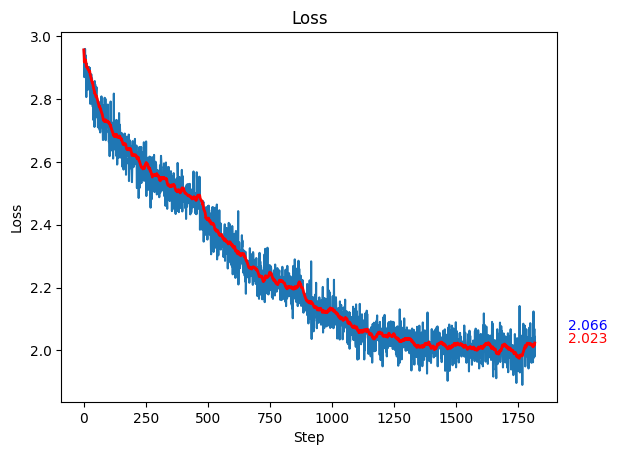

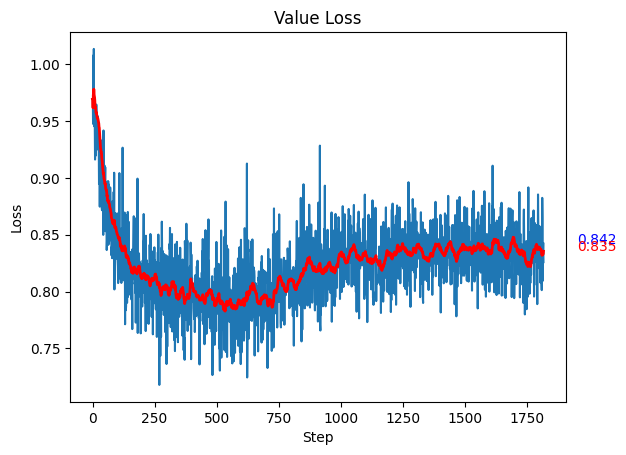

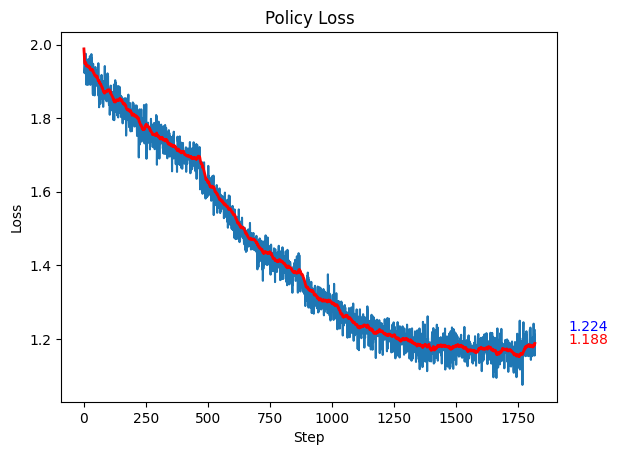

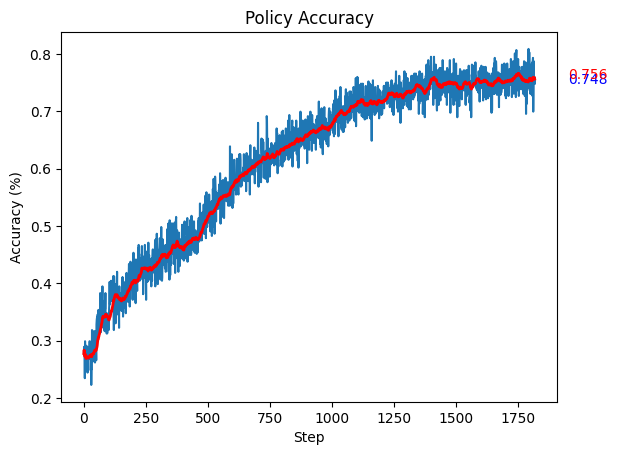

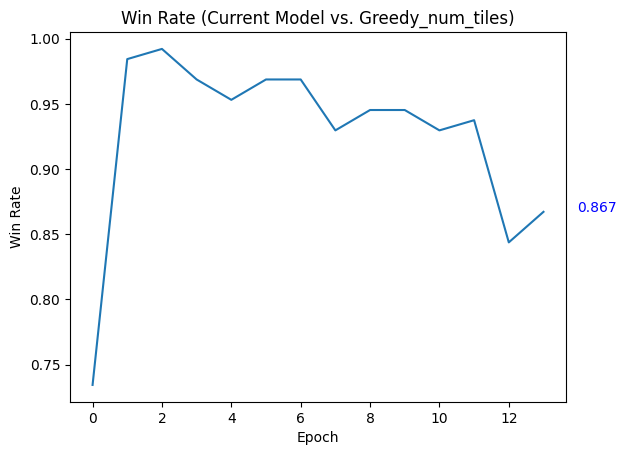

KeyboardInterrupt: ignored

In [7]:
trainer.training_loop(epochs=15)

## Test Mode

Next, we can experiment with the `Tester`, which allows us to test trained models against a variety of baselines. We can define a new config file as follows:

In [ ]:
%%writefile test_config.yaml
run_tag: "othello_hello_world" # for saving and identifying checkpoints
env_config: { # configures the environment
  env_type: "othello", # type of environment
  board_size: 8 # size of Othello board (8x8)
}
test_mode_config: {
  algo_config: { # configuration of the algorithm we'd like to test (same as before, although you could change things up!)
      name: "alphazero",
      temperature: 0.0,
      num_iters: 400,
      max_nodes: 400,
      puct_coeff: 1.0,
      dirichlet_alpha: 0.1,
      dirichlet_epsilon: 0.0
  },
  episodes_per_epoch: 32,
  baselines: [ # 32 episodes will be collected against each of the following:
    {
      name: 'greedy', # prioritizes moves that capture corner squares
      heuristic: 'corners'
    },
    {
      name: 'greedy', # prioritizes moves that capture corner and edge squares
      heuristic: 'corners_and_edges'
    },
    {
      name: 'greedy', # minimizes the number of moves available to the opponent
      heuristic: 'minmax_moves'
    },
    {
      name: 'greedy', # maximizes the (immediate) quantity of tiles it controls
      heuristic: 'num_tiles'
    },
  ]
}

For more info on testing & evaluation configuration, see the [wiki page](https://github.com/lowrollr/turbozero/wiki/Evaluation-&-Testing).

This configuration allows us to test against 4 different greedy algorithms:
* `corners`: prirotizes placing tiles in corners squares (cannot be re-captured)
* `corners_and_edges`: prioritizes placing tiles in corner and edge squares
* `minmax_moves`: prioritizes limiting the amount of moves the opponent can make
* `num_tiles`: prioritizes maximizing the number of tiles of its own color


You can view the source code for each of these heuristics [here](https://github.com/lowrollr/turbozero/blob/760a26fdb92423a93bd01ac56deb5c4bfb0b273e/envs/othello/env.py#L195).

We will play 32 games against each.

In [ ]:
from turbozero import load_tester_nb

tester = load_tester_nb(
    config_file = 'test_config.yaml',
    gpu = torch.cuda.is_available(),
    debug = False,
    logfile = '',
    verbose_logging=True,
    checkpoint = './checkpoints/othello_hello_world/20.pt'
)

In [ ]:
tester.collect_test_batch()

In [ ]:
! tail -n 16 turbozero.log

## Tournament Mode

While these head-to-head results are insightful, to get a better idea of the relative strength of our model compared to stronger algorithms and previous generations of the neural network, we can run a round-robin tournament. After the tournament are complete, we can calculate an [Elo](https://en.wikipedia.org/wiki/Elo_rating_system) rating for each algorithm instance, which helps gives us a better measure of relative strength.

In [ ]:
%%writefile tournament_config.yaml
run_tag: "othello_hello_world" # for saving and identifying checkpoints
env_config: { # configures the environment
  env_type: "othello", # type of environment
  book: '../envs/othello/misc/book.txt',
  board_size: 8 # size of Othello board (8x8)
}
tournament_mode_config: {
  num_games: 128,
  num_tournaments: 64,
  tournament_name: 'test123',
  competitors: [
    {
      name: 'az_20',
      algo_config: {
        name: "alphazero",
        temperature: 0.0,
        num_iters: 400,
        max_nodes: 400,
        puct_coeff: 1.0,
        dirichlet_alpha: 0.1,
        dirichlet_epsilon: 0.0
      },
      checkpoint: './checkpoints/othello_hello_world/20.pt'
    },
    {
      name: 'az_5',
      algo_config: {
        name: "alphazero",
        temperature: 0.0,
        num_iters: 400,
        max_nodes: 400,
        puct_coeff: 1.0,
        dirichlet_alpha: 0.1,
        dirichlet_epsilon: 0.0
      },
      checkpoint: './checkpoints/othello_hello_world/5.pt'
    },
    {
      name: 'gmcts_tiles',
      algo_config: {
        name: "greedy_mcts",
        heuristic: "num_tiles",
        num_iters: 400,
        max_nodes: 400,
        puct_coeff: 1.0,
        dirichlet_alpha: 0.1,
        dirichlet_epsilon: 0.0,
      },
    },
    {
      name: 'gmcts_corners_and_edges',
      algo_config: {
        name: "greedy_mcts",
        heuristic: "corners_and_edges",
        num_iters: 400,
        max_nodes: 400,
        puct_coeff: 1.0,
        dirichlet_alpha: 0.1,
        dirichlet_epsilon: 0.0,
      },
    },
    {
      name: 'random',
      algo_config: {
        name: "random"
      },
    },
  ]
}

This configuration gives a much stronger gauntlet of opponents compared to those faced previously. These include:
* the `5th` generation NN
* `num_tiles` greedy algorithm, except its used as an evaluation function in Monte Carlo Tree Search with identical parameters to our current model (400 iters, etc)
* `corners_and_edges` greedy algorithm, except its used as an evaluation function in Monte Carlo Tree Search with identical parameters to our current model (400 iters, etc)
* `random` (makes a random move), to serve as a baseline

In [ ]:
from turbozero import load_tournament_nb

tournament, competitors = load_tournament_nb(
    config_file = 'tournament_config.yaml',
    gpu = torch.cuda.is_available(),
    debug = False,
    logfile = '',
    verbose_logging=True,
)

In [ ]:
tournament.run(competitors, interactive=True)

The matrix above shows the Elo ratings acheived by each algorithm, as well as the win-rates for each matchup.

## Demo Mode

Finally, we can use Demo mode to play a game against our trained model (good luck!).

In [ ]:
%%writefile demo_config.yaml
env_config: {
  env_type: 'othello',
  board_size: 8
}
demo_config: {
  evaluator1_config: {
    algo_config: {
      name: 'alphazero',
      temperature: 0.0,
      num_iters: 200,
      max_nodes: 200,
      puct_coeff: 1.0,
      dirichlet_alpha: 0.1,
      dirichlet_epsilon: 0.0
    },
    checkpoint: './checkpoints/othello_hello_world/20.pt'
  },
  evaluator2_config: {
    algo_config: {
      name: 'human'
    }
  },
  manual_step: False
}

In [ ]:
from turbozero import load_demo_nb
demo = load_demo_nb(
    config_file = './demo_config.yaml',
)
demo.run(interactive=True)

For more information on algorithm implementations, configuration options, and anything else you might want to know, please consult the [Wiki](https://github.com/lowrollr/turbozero/wiki)!